In [1]:
from keras.optimizers import Adam
from keras.models import Model, Sequential
from keras.layers import Input, InputLayer, Dense, BatchNormalization, Dropout, Flatten, Reshape


class Autoencoder:
    def __init__(self, img_shape=(90, 90, 3), code_size=128, hidden_size=512):
        # Basic input parameters
        self.img_shape = img_shape
        self.code_size = code_size
        self.hidden_size = hidden_size
        self.default_weights_folder = "model_weights"
        self.default_encoder_weights_path = f"{self.default_weights_folder}/encoder_weights.txt"
        self.default_decoder_weights_path = f"{self.default_weights_folder}/decoder_weights.txt"

        # Compile model
        self.encoder, self.decoder = self.build_autoencoder(img_shape, code_size, hidden_size)
        inp = Input(self.img_shape)
        code = self.encoder(inp)
        reconstruction = self.decoder(code)
        self.autoencoder = Model(inputs=inp, outputs=reconstruction)
        self.autoencoder.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy')

    # \brief Fit method wrapper
    # Note that y_train == x_train, y_val == x_val, because this is unsupervised learning model
    def fit(self, x_train, x_val, epochs, batch_size=128, verbose=1):
        self.autoencoder.fit(x=x_train, y=x_train, epochs=epochs, batch_size=batch_size,
                             validation_data=[x_val, x_val], verbose=verbose)

    # \brief Predict method wrapper
    def predict(self, data):
        return self.autoencoder.predict(data)

    # \brief Single image predict wrapper
    def predict_img(self, img):
        # img[None] is the same as img[np.newaxis, :]
        return self.autoencoder.predict(img[None])[0]

    # \brief Single code predict wrapper
    def predict_img_code(self, img):
        # img[None] is the same as img[np.newaxis, :]
        return self.encoder.predict(img[None])[0]

    # \brief Single code reconstruction predict wrapper
    def predict_code_reconstruction(self, code):
        # img[None] is the same as img[np.newaxis, :]
        return self.decoder.predict(code[None])[0]

    # \brief Load pretrained model weights
    def load_weights(self, encoder_weights_path=None, decoder_weights_path=None):
        if encoder_weights_path is None:
            encoder_weights_path = self.default_encoder_weights_path
        if decoder_weights_path is None:
            decoder_weights_path = self.default_decoder_weights_path
        self.encoder.load_weights(encoder_weights_path)
        self.decoder.load_weights(decoder_weights_path)

    # \brief Deep autoencoder network construction
    # \return encoder -- encoding part, which compress image to the code
    # \return decoder -- decoding part, which reconstruct image for input code
    @staticmethod
    def build_autoencoder(img_shape=(90, 90, 3), code_size=128, hidden_size=512):
        # encoder
        encoder = Sequential()
        encoder.add(InputLayer(img_shape))
        encoder.add(Flatten())
        encoder.add(Dense(hidden_size * 2, activation='relu'))
        encoder.add(BatchNormalization())
        encoder.add(Dropout(0.3))
        encoder.add(Dense(hidden_size, activation='relu'))
        encoder.add(BatchNormalization())
        encoder.add(Dropout(0.3))
        encoder.add(Dense(code_size, activation='relu'))
        # decoder
        decoder = Sequential()
        decoder.add(InputLayer((code_size,)))
        decoder.add(Dense(hidden_size, activation='relu'))
        decoder.add(BatchNormalization())
        decoder.add(Dropout(0.3))
        decoder.add(Dense(hidden_size * 2, activation='relu'))
        decoder.add(BatchNormalization())
        decoder.add(Dropout(0.3))
        decoder.add(Dense(img_shape[0] * img_shape[1] * img_shape[2], activation='sigmoid'))
        decoder.add(Reshape(img_shape))
        return encoder, decoder

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
import os
os.chdir("/content/gdrive/My Drive/autoencoders")

In [0]:
import os
import pandas as pd
import numpy as np
from skimage.io import imread
from skimage.transform import resize
from tqdm import tqdm

dataset_path = "lfw_dataset"
images_name = "lfw-deepfunneled"
attrs_name = "lfw_attributes.txt"


def get_lfw_dataset():
    if not os.path.exists(dataset_path):
        os.mkdir(dataset_path)

    os.chdir(dataset_path)

    if not os.path.exists(images_name):
        print("images not found, downloading...")
        os.system(f"wget http://vis-www.cs.umass.edu/lfw/{images_name}.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        assert os.path.exists(images_name)
        print("done")

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system(f"wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/{attrs_name}")
        assert os.path.exists(attrs_name)
        print("done")

    os.chdir("..")


def del_vlw_dataset():
    import shutil
    if os.path.exists(dataset_path):
        print("deleting dataset...")
        shutil.rmtree(dataset_path)
        assert not os.path.exists(dataset_path)
        print("done")


def load_data(dx=80, dy=80, dimx=45, dimy=45):
    # fetch dataset
    if not os.path.exists(dataset_path):
        get_lfw_dataset()

    os.chdir(dataset_path)

    # read attrs
    df_attrs = pd.read_csv(attrs_name, sep='\t', skiprows=1)
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])
    df_attrs = df_attrs.astype({"imagenum": int})

    # read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})
    photo_ids = pd.DataFrame(photo_ids)
    print("done")

    print(df_attrs.head())
    print(photo_ids.head())

    # mass-merge (photos now have same order as attributes)
    df = pd.merge(df_attrs, photo_ids, on=('person', 'imagenum'))
    assert len(df) == len(df_attrs), "lost some data when merging dataframes"

    # image preprocessing   
    all_photos = df['photo_path'].apply(imread)
    print("Apply 1 finished")
    all_photos = all_photos.apply(lambda img : img[dy:-dy,dx:-dx])
    print("Apply 2 finished")
    # all_photos = all_photos.apply(lambda img : resize(img, [dimx, dimy], mode='reflect', anti_aliasing=True))
    # print("Apply 3 finished")
                                
    all_photos = np.stack(all_photos.values).astype('float32')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    os.chdir("..")

    return all_photos, all_attrs

In [0]:
import numpy as np
#data, attrs = load_data()
data = np.load('data_90.npy')

In [5]:
ae = Autoencoder()
ae.load_weights('encoder_weights_171.txt', 'decoder_weights_171.txt')

W0627 09:24:15.858528 139920211842944 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0627 09:24:16.760316 139920211842944 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0627 09:24:16.784602 139920211842944 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0627 09:24:16.876975 139920211842944 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0627 09:24:16.901972 

In [0]:
import matplotlib.pyplot as plt
from skimage.io import imsave
import warnings
warnings.filterwarnings('ignore')

def reconstruct_image(img,dims=(90,90,3)):
    img = img.reshape(*dims)# * 255.
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    plt.imshow(img)

(90, 90, 3)


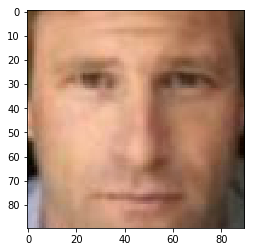

In [8]:
img = data[0].astype('float32')/255 #reconstruct_image(data[500])
print(img.shape)
reconstruct_image(img)
#imsave('clean_img.jpg', data[500])

(90, 90, 3)


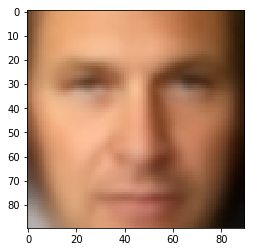

In [9]:
print(ae.predict_img(img).shape)
reconstruct_image(ae.predict_img(img))
#imsave('mod_img.jpg', img)

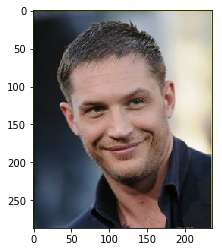

In [10]:
from skimage.io import imread
from skimage.transform import resize

photo = imread('male_3.jpg')
plt.imshow(photo)

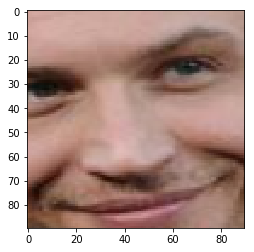

In [11]:
def validate_raw_user_photo(photo):  
  return True

def prepare_raw_user_photo(photo, dx=90, dy=90, dimx=270, dimy=270):
  photo = resize(photo, [dimx, dimy], mode='reflect', anti_aliasing=True)  
  photo = photo[dy:-dy, dx:-dx]  
  photo = photo.astype('float32')
  return photo

user_photo = prepare_raw_user_photo(photo)
plt.imshow(user_photo, cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')

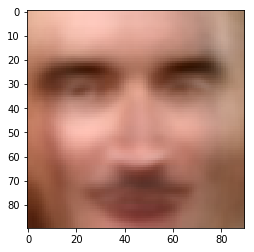

In [12]:
img = reconstruct_image(ae.predict_img(user_photo))
#plt.imshow(img, cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')

In [0]:
#latent_space_dim = ae.code_size
imgs = data.astype('float32')/255
code = ae.encoder.predict(imgs)
mu, sigma = np.mean(code), np.var(code)
z = np.random.normal(0, 1, code.shape)


In [14]:
# задай mu,sigma и посмотри, прямую трансляцию из пространсва латентных векторов
print(mu, sigma, code.shape)

2.7977695 8.499946 (13143, 128)


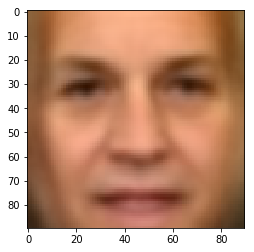

In [15]:
reco = ae.decoder.predict(z[1232][None])[0]
reconstruct_image(reco)

In [0]:
smily_data_id     = [60, 135, 155, 175, 235, 285, 305, 375, 425, 445, 7749, 505, 525, 535, 1146]
not_smily_data_id = [55, 94, 105, 195, 295, 335, 365, 415, 455, 465, 545, 745, 746, 4745, 8749]

smily_data  = np.array([imgs[i] for i in smily_data_id])
not_smily_data  = np.array([imgs[i] for i in not_smily_data_id])

np.save('smily_data_90.npy', smily_data)
np.save('not_smily_data_90.npy', not_smily_data)

In [0]:
smily_code = ae.encoder.predict(smily_data)
not_smily_code = ae.encoder.predict(not_smily_data)
happiness_code = np.mean(smily_code, axis=0) - np.mean(not_smily_code, axis=0)
np.save('happiness_code_90.npy', happiness_code)

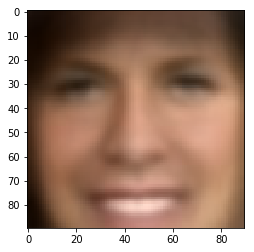

In [23]:
random_code = ae.encoder.predict(imgs[377][None])[0]
#smily_img = ae.decoder.predict((smily_code[11] + 3 * happiness_code)[None])[0]
smily_img = ae.decoder.predict((random_code + 1 * happiness_code)[None])[0]
reconstruct_image(smily_img)